In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV , StratifiedKFold , cross_val_score




In [3]:
train=pd.read_csv("../input/titanic/train.csv")
test=pd.read_csv("../input/titanic/test.csv")

# データの結合

In [4]:
df = pd.concat([train, test], axis=0, sort=False)

# データの概要と欠損値の確認

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


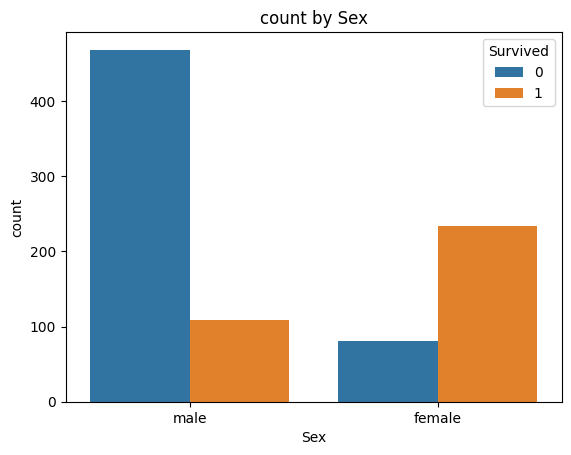

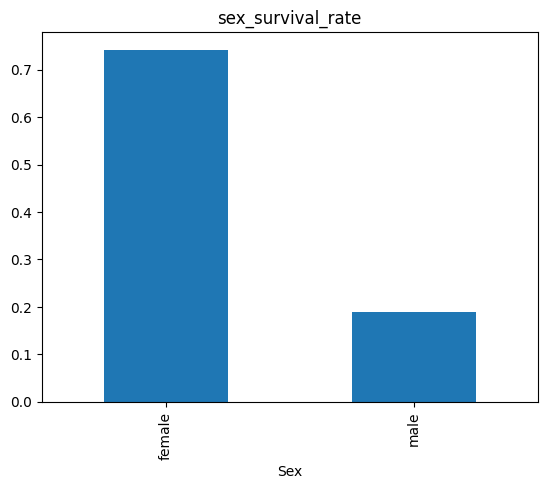

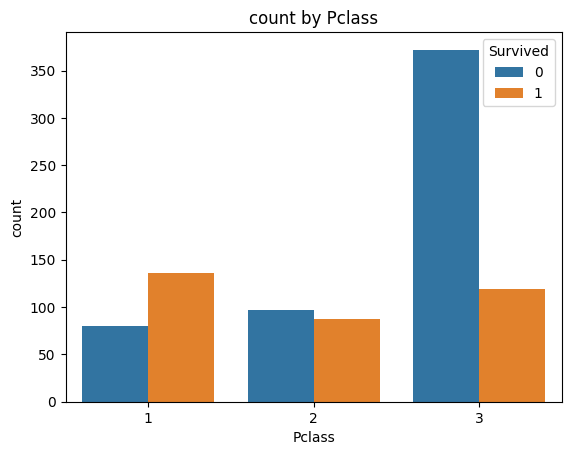

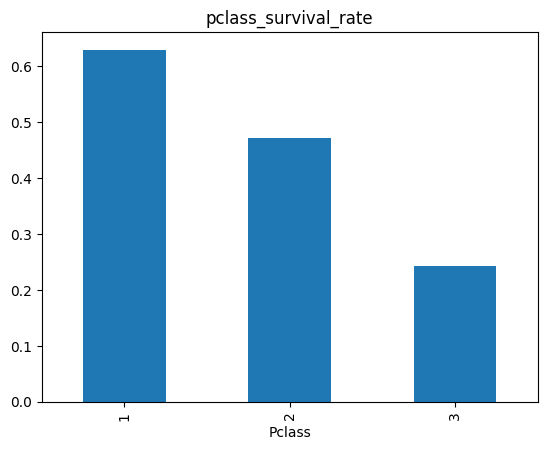

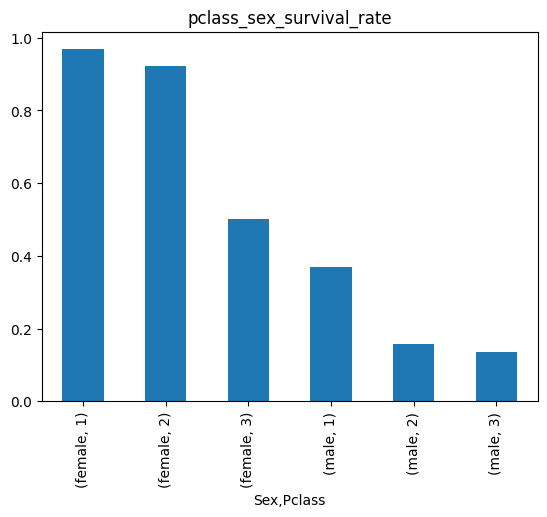

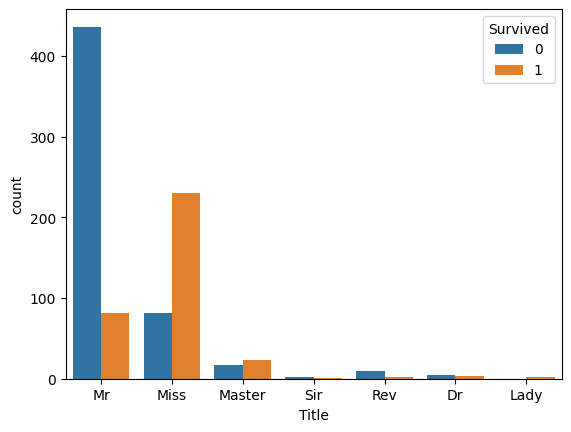

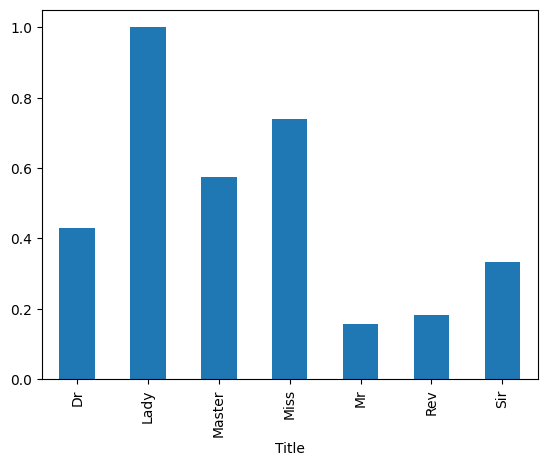

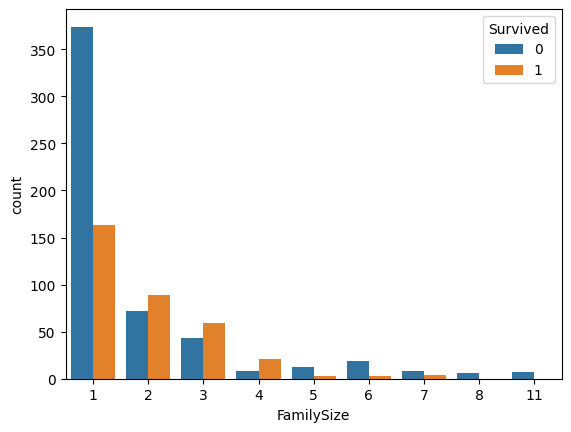

/tmp/ipykernel_13/1209450815.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Age"].fillna(train.groupby("Title")["Age"].transform("median"),inplace=True)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.

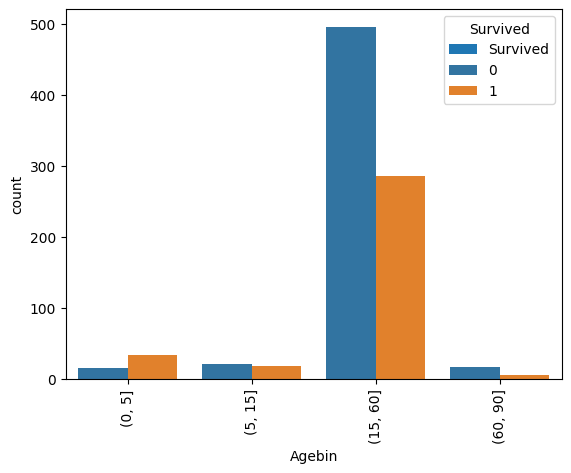

/tmp/ipykernel_13/1209450815.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agebin_survival_rate=train.groupby(["Agebin"])["Survived"].mean()


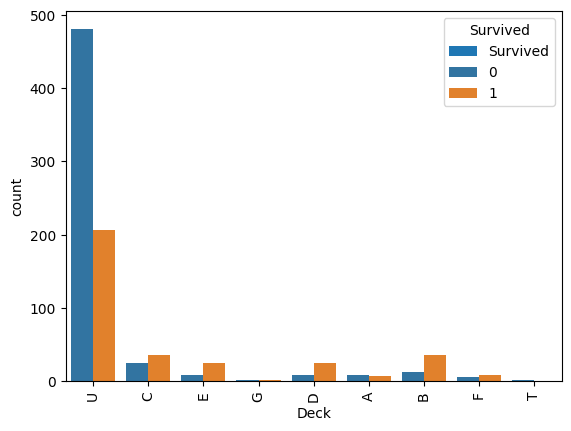

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


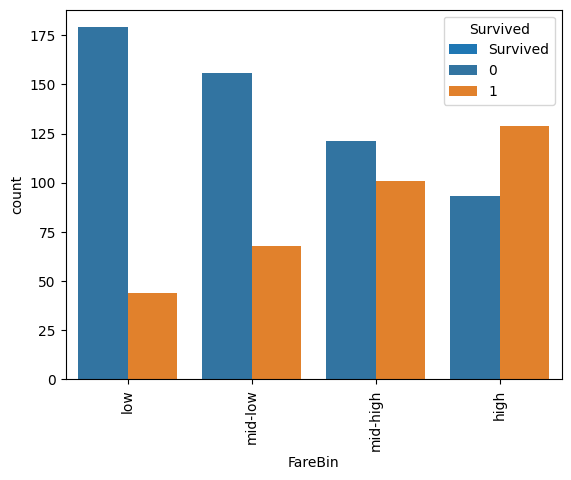

In [6]:
#Sexは強い関係があろう
sns.countplot(data=train , hue="Survived" , x="Sex")
plt.title("count by Sex")
plt.show()
sex_survival_rate=train.groupby("Sex")["Survived"].mean()
sex_survival_rate.plot(kind="bar")
plt.title("sex_survival_rate")
plt.show()

#Pclassも強い関係が合
sns.countplot(data=train , hue="Survived" , x="Pclass")
plt.title("count by Pclass")
plt.show()
pclass_survival_rate=train.groupby("Pclass")["Survived"].mean()
pclass_survival_rate.plot(kind="bar")
plt.title("pclass_survival_rate")
plt.show()


#pclassとSexは独立
pclass_sex_survival_rate=train.groupby(["Sex","Pclass"])["Survived"].mean()
pclass_sex_survival_rate.plot(kind="bar")
plt.title("pclass_sex_survival_rate")
plt.show()

#titleを作る titleは強い関係がありそう
train["Title"]=train["Name"].str.extract("([A-Za-z]+)\.")
train["Title"]=train["Title"].replace(["Miss","Mrs","Ms", "Mlle", "Mme"] ,"Miss")#Masterはそのまま
train["Title"]=train["Title"].replace(["Rev", "Col", "Major", "Capt"] ,"Rev")
train["Title"]=train["Title"].replace(["Lady" , "Countess" ,"Dona"] ,"Lady")
train["Title"]=train["Title"].replace(["Jonkheer" ,"Don" ,] ,"Sir")
sns.countplot(data=train , x="Title" , hue="Survived")
plt.show()
title_survival_rate=train.groupby("Title")["Survived"].mean()
title_survival_rate.plot(kind="bar")
plt.show()

#FamilySize
train["FamilySize"]=train["Parch"] + train["SibSp"]+1
sns.countplot(data=train , x="FamilySize" , hue="Survived")
plt.show()
familysize_survival_rate=train.groupby("FamilySize")["Survived"].mean()
familysize_survival_rate.plot(kind="bar")
train["IsAlone"]=(train["FamilySize"]==1).astype(int)#>=5で作っても良さそう、男性なら一人が多いとかだと不要なことになる

#Agebinは凄そうだが、titleとの関係はどうなのだろう
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"),inplace=True)
agebin=[0,5,15,60,90]
train["Agebin"]=pd.cut(train["Age"] , agebin)
sns.countplot(data=train , x="Agebin" , hue="Survived")
plt.show()
agebin_survival_rate=train.groupby(["Agebin"])["Survived"].mean()
agebin_survival_rate.plot(kind="bar")

#Cabinは関係がありそうだが、pclassとの関係はどうなのだろう
train["Deck"] =train["Cabin"].fillna("U").str[0]
sns.countplot(train,x="Deck" ,hue="Survived")
plt.show()
deck_survival_rate=train.groupby("Deck")["Survived"].mean()
deck_survival_rate.plot(kind="bar")

#fareは関係ありそうだけど、pclassやdeckとの関係次第
train["FareBin"] = pd.qcut(train["Fare"], 4, labels=["low", "mid-low", "mid-high", "high"])
sns.countplot(data=train , x="FareBin" , hue="Survived")
plt.show()

In [7]:
#titleを作る
test["Title"]=test["Name"].str.extract("([A-Za-z]+)\.")
test["Title"]=test["Title"].replace(["Miss","Mrs","Ms", "Mlle", "Mme"] ,"Miss")#Masterはそのまま
test["Title"]=test["Title"].replace(["Rev", "Col", "Major", "Capt"] ,"Rev")
test["Title"]=test["Title"].replace(["Lady" , "Countess" ,"Dona"] ,"Lady")
test["Title"]=test["Title"].replace(["Jonkheer" ,"Don",] ,"Sir")

#FamilySizeを作る
test["FamilySize"]=test["Parch"] + test["SibSp"]+1

#IsAloneを作る

test["IsAlone"]=(test["FamilySize"]==1).astype(int)

#Agebinを作る
title_age_median = train.groupby("Title")["Age"].median()

# ② testのAgeを、trainの中央値で補完（mapとfillnaを組み合わせる）
test["Age"] = test["Age"].fillna(test["Title"].map(title_age_median))
agebin=[0,5,15,60,90]
test["Agebin"]=pd.cut(test["Age"] , agebin)


#Deckを作る
test["Deck"] =test["Cabin"].fillna("U").str[0]

#Farebinを作る
# trainでqcutしたときの境界を保存
fare_class_title_median = train.groupby(["Pclass", "Title"])["Fare"].median()
test["Fare"] = test["Fare"].fillna(
    test[["Pclass", "Title"]].apply(tuple, axis=1).map(fare_class_title_median)
)
# testに同じbinを使う
# train の Fare を4等分して bin の境界を保存
train["FareBin"], bin_edges = pd.qcut(train["Fare"], 4, labels=["low", "mid-low", "mid-high", "high"], retbins=True)

# test でも同じ bin を使って分類（これでエラー解消）
test["FareBin"] = pd.cut(test["Fare"], bins=bin_edges, labels=["low", "mid-low", "mid-high", "high"], include_lowest=True)

#3等の女性に限ってみる
train_3_female=train[(train["Sex"]=="female") & (train["Pclass"]==3)]
train_3_female.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Agebin,Deck,FareBin
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,"(15, 60]",U,mid-low
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Miss,3,0,"(15, 60]",U,mid-low
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss,3,0,"(0, 5]",G,mid-high
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,Miss,1,1,"(5, 15]",U,low
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S,Miss,2,0,"(15, 60]",U,mid-high


In [8]:
#前処理 labelencoderでやってみた（改善の余地あり）
le_dict = {}
for col in ["Sex" ,"Pclass" ,"Agebin" ,"FamilySize" ,"Title" ,"FareBin"]:
    le = LabelEncoder()
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])  # 一貫性を保つ
    train_3_female[col]=le.transform(train_3_female[col])
    le_dict[col] = le

deck_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7,"U":0,"T":0}
train['Deck'] = train['Deck'].map(deck_map)
test['Deck'] = test['Deck'].map(deck_map)
train_3_female["Deck"]=train_3_female["Deck"].map(deck_map)


features = ["Sex", "Pclass", "Deck", "FamilySize","Title", "Age","Fare"]
train[features].head()
X_train=train[features]
y=train["Survived"]
X_train,X_val,y_train,y_val=train_test_split(X_train , y ,test_size=0.2 , random_state=2)

X_train_3_female=train_3_female[features]
y_train_3_female=train_3_female["Survived"]
X_train_3_female

/tmp/ipykernel_13/2205432428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3_female[col]=le.transform(train_3_female[col])
/tmp/ipykernel_13/2205432428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3_female[col]=le.transform(train_3_female[col])
/tmp/ipykernel_13/2205432428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,Sex,Pclass,Deck,FamilySize,Title,Age,Fare
2,0,2,0,0,3,26.0,7.9250
8,0,2,0,2,3,27.0,11.1333
10,0,2,7,2,3,4.0,16.7000
14,0,2,0,0,3,14.0,7.8542
18,0,2,0,1,3,31.0,18.0000
...,...,...,...,...,...,...,...
863,0,2,0,8,3,27.0,69.5500
875,0,2,0,0,3,15.0,7.2250
882,0,2,0,0,3,22.0,10.5167
885,0,2,0,5,3,39.0,29.1250


In [9]:
#RandomForestのハイパーパラメータのチューニング
cv = StratifiedKFold(n_splits=5 , shuffle=True ,random_state=42)
params={"n_estimators" :[50,100,200],
           "max_depth" :[3,5,10],
           "min_samples_leaf" :[1,5,10],
           "random_state" :[42]}
rf=RandomForestClassifier()
grid_search=GridSearchCV(rf,param_grid=params,cv=cv,n_jobs=-1)

grid_search.fit(X_train,y_train)
print("最良パラメータ:",grid_search.best_params_)
#100,5,5  200,10,6
print("検証セット正答率:" ,grid_search.score(X_val,y_val))

最良パラメータ: {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200, 'random_state': 42}
検証セット正答率: 0.8100558659217877


In [10]:
#lightgbmを使う
model=lgb.LGBMClassifier(random_state=0)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],  # 検証用データを指定
          callbacks=[lgb.early_stopping(100, verbose=False)])
print("訓練データ" ,model.score(X_train,y_train))
print("テストデータ" ,model.score(X_val,y_val))

[LightGBM] [Info] Number of positive: 263, number of negative: 449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369382 -> initscore=-0.534869
[LightGBM] [Info] Start training from score -0.534869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [11]:
#RandomForestClassifierの検証
model=RandomForestClassifier(n_estimators=200,max_depth=10,min_samples_leaf=10,random_state=42)
model.fit(X_train,y_train)
print("訓練データ",model.score(X_train,y_train))
print("検証データ",model.score(X_val,y_val))


#print("3等の女性の正答率",model.score(X_train_3_female,y_train_3_female))
print("3等の女性の正答率",model.score(X_train_3_female,y_train_3_female))

訓練データ 0.851123595505618
検証データ 0.8100558659217877
3等の女性の正答率 0.7013888888888888


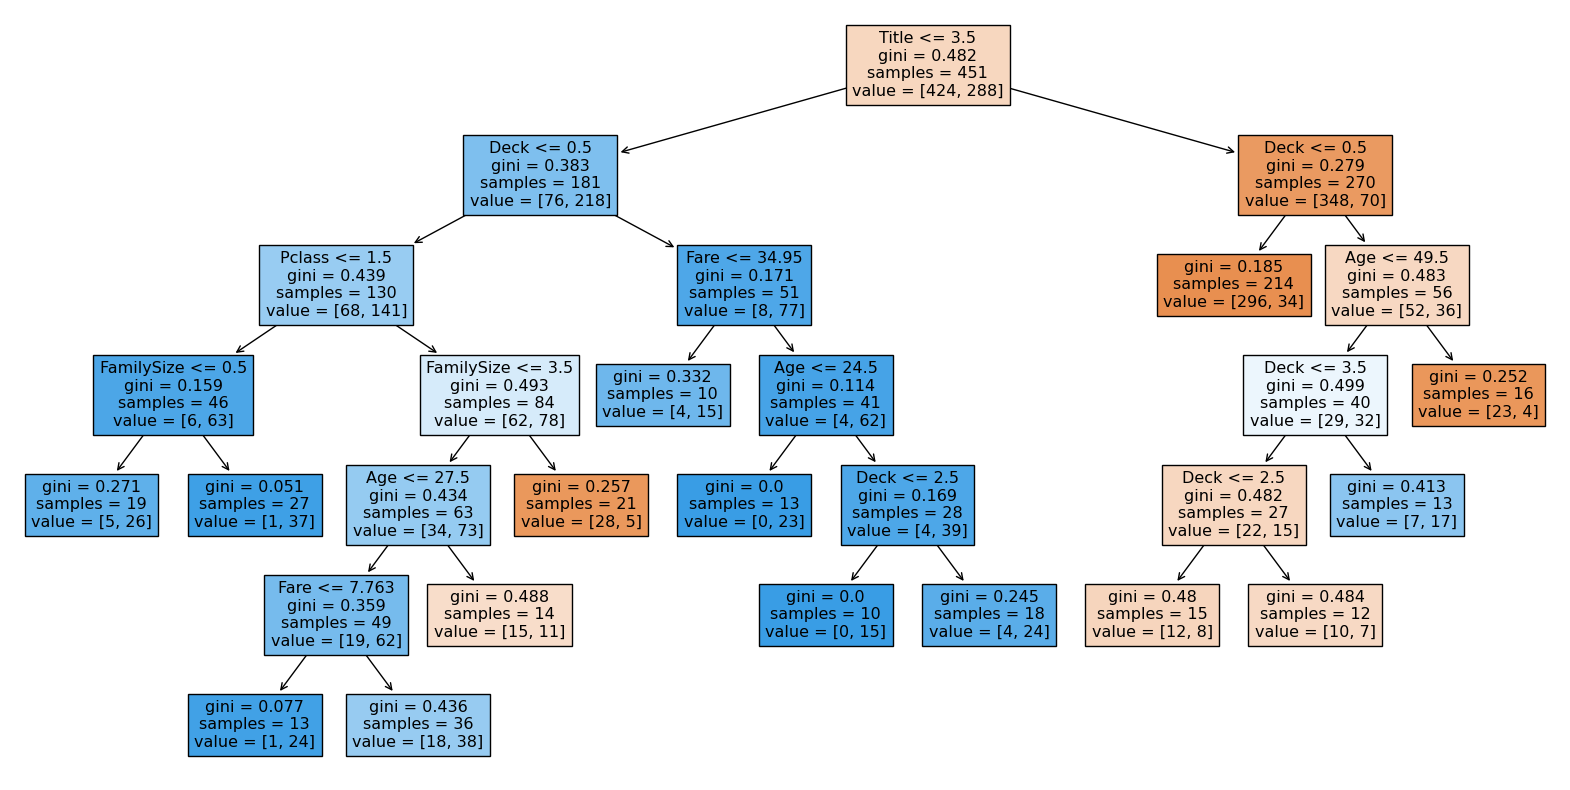

In [12]:
#randomforestの中身の確認
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 最初の1本目の木を表示
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()


In [13]:

X_test=test[features]
y_test_pred=model.predict(X_test)
submission=pd.DataFrame({"PassengerId" : test["PassengerId"] 
                        ,"Survived" : y_test_pred})
submission.to_csv("submission.csv",index=False)

In [14]:
import os

# 保存先ファイル一覧を確認
print(os.listdir("/kaggle/working"))


['submission.csv', '__notebook__.ipynb']
